In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
import imghdr 

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout , AveragePooling2D , BatchNormalization

from tensorflow.keras.metrics import Precision , Recall , BinaryAccuracy

from tensorflow.keras.models import load_model

In [76]:
plt.style.use("ggplot")

In [3]:
vgg = VGG16(input_shape = [224 , 224 , 3] , weights = "imagenet" , include_top = False)

58889256/58889256 [==============================] - 8s 0us/step


In [5]:
for layer in vgg.layers:
    layer.trainable = False

In [6]:
data_dir = "data"
os.listdir(data_dir)

['ballerina cappuccina',
 'brr brr patapim',
 'lirili larila',
 'tralalero tralala',
 'tung tung tung sahur']

In [8]:
x = Flatten()(vgg.output)

In [13]:
prediction = Dense(len(os.listdir(data_dir)), activation='softmax')(x)

In [17]:
vgg16 = Model(inputs = vgg.input , outputs = prediction)

In [18]:
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
vgg16.compile( optimizer = "adam" ,  loss = tf.losses.SparseCategoricalCrossentropy() , metrics = ["accuracy"] )

In [32]:
valid = ["jpeg" , "jpg" , "bmp" , "png"]
for image_class in os.listdir(data_dir) :
    for image in os.listdir(os.path.join(data_dir , image_class)) :
        image_path = os.path.join(data_dir , image_class , image)
        try :
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in valid :
                os.remove(image_path)
        except Exception as e :
            continue

In [33]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 550 files belonging to 5 classes.


In [34]:
data_iterator = data.as_numpy_iterator() 

In [35]:
batch = data_iterator.next() 

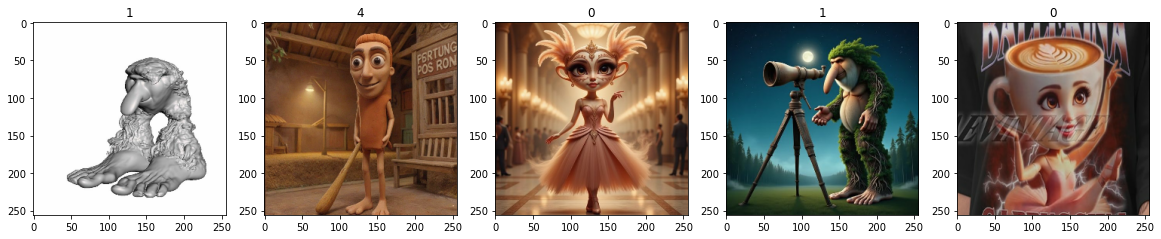

In [36]:
fig , ax = plt.subplots(ncols = 5 , figsize = (20,20))
for idx , img in enumerate(batch[0][:5]) :  
    ax[idx].imshow(img.astype("uint8"))
    ax[idx].title.set_text(batch[1][idx])

In [37]:
scaled = data.map(lambda x, y: (tf.image.resize(x, [224 , 224]) / 255.0, y)) 

scaled_iterator = scaled.as_numpy_iterator()

train_size = int(len(scaled) * 0.7)
test_size = int(len(scaled) * 0.1) + 1
val_size = int(len(scaled) * 0.2) + 1

train = scaled.take(train_size)
test = scaled.skip(train_size).take(test_size)
val = scaled.skip(train_size + test_size).take(val_size)

In [38]:
logdir = "logs_vgg"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [39]:
hist = vgg16.fit(train , epochs = 20 , validation_data = val , callbacks = [tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 367s 31s/step - loss: 1.3562 - accuracy: 0.5104 - val_loss: 0.4820 - val_accuracy: 0.8529
Epoch 2/20
12/12 [==============================] - 341s 29s/step - loss: 0.2496 - accuracy: 0.9271 - val_loss: 0.1680 - val_accuracy: 0.9412
Epoch 3/20
12/12 [==============================] - 345s 29s/step - loss: 0.1196 - accuracy: 0.9766 - val_loss: 0.1372 - val_accuracy: 0.9608
Epoch 4/20
12/12 [==============================] - 369s 31s/step - loss: 0.0528 - accuracy: 0.9922 - val_loss: 0.0902 - val_accuracy: 0.9804
Epoch 5/20
12/12 [==============================] - 337s 28s/step - loss: 0.0352 - accuracy: 0.9948 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 339s 29s/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0289 - val_accuracy: 0.9902
Epoch 7/20
12/12 [==============================] - 337s 28s/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 

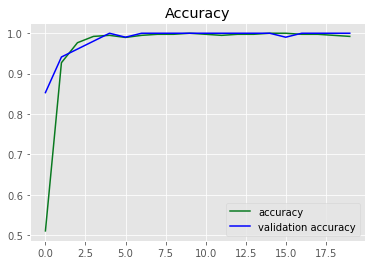

In [82]:
plt.plot(hist.history["accuracy"] , color = "#097A20" , label = "accuracy")
plt.plot(hist.history["val_accuracy"] , color = "blue" , label = "validation accuracy")
plt.title("Accuracy")
plt.legend(loc = "lower right")
plt.show()

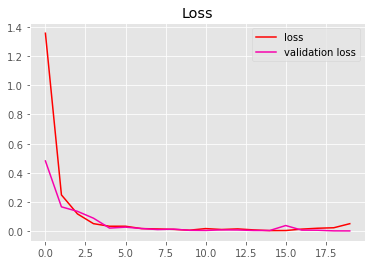

In [81]:
plt.plot(hist.history["loss"] , color = "red" , label = "loss")
plt.plot(hist.history["val_loss"] , color = "#F702AD" , label = "validation loss")
plt.title("Loss")
plt.legend(loc = "upper right")
plt.show()

In [42]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test.as_numpy_iterator():
    x, y = batch
    
    yhat = vgg16.predict(x)

    y_pred = tf.argmax(yhat, axis = 1 , output_type = tf.int64)

    y_true = tf.convert_to_tensor(y , dtype = tf.int64)

    # Update metrics
    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

1/1 [==============================] - 22s 22s/step


In [45]:
print(f"Precision : {pre.result()} , Recall : {re.result()} , Accuracy : {acc.result()}")

Precision : 1.0 , Recall : 1.0 , Accuracy : 0.390625


[]

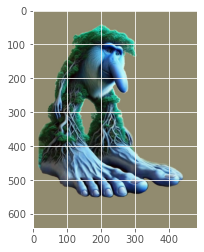

In [90]:
img = cv.imread("patapim_test.png")
plt.imshow(img)
plt.plot()

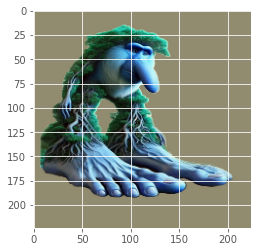

In [91]:
resize = tf.image.resize(img , (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [92]:
yhat = vgg16.predict(np.expand_dims(resize/255 , 0))
ans = list(yhat[0]).index(max(list(yhat[0])))
if(ans == 0) :
    print("Ballerina Cappucina")
elif (ans == 1) :
    print("Brr Brr Patapim")
elif (ans == 2) :
    print("Lirilla Larila")
elif (ans == 3) :
    print("Tralalero Tralala")
elif (ans == 4) :
    print("Tung Tung Tung Tung Tung Tung Tung Sahur")

1/1 [==============================] - 1s 760ms/step
Brr Brr Patapim


In [93]:
yhat = vgg16.predict(np.expand_dims(resize/255 , 0))
prob_matrix = list(yhat[0])
for x in range(len(prob_matrix)) :
    if(prob_matrix[x] > 0.8 ) :
        if(x == 0) :
            print("Ballerina Cappucina")
        elif(x == 1) :
            print("Brr Brr Patapim")
        elif(x == 2) :
            print("Lirilla Larila")
        elif(x == 3) :
            print("Tralalero Tralala")
        elif(x == 4) :
            print("Tung Tung Tung Tung Tung Tung Tung Sahur")
print(prob_matrix)   

1/1 [==============================] - 1s 751ms/step
Brr Brr Patapim
[1.9408342e-06, 0.9999796, 1.4753989e-05, 3.1041961e-06, 6.1285874e-07]


In [52]:
vgg16.save(os.path.join("models" , "breinrot_classifier_vgg16.keras"))